In [28]:
import watvina.watvina_python as pywatvina
from watvina.rdkit2pdbqt import *

In [29]:
#Step 1: initiate a WATVina task
wv = pywatvina.WATVina(cpu=8,seed=0,verbosity=1)
#详细使用说明
#help(wv)

In [30]:
#Step 2: Import receptor
#from a pdb file
receptor_mol=Chem.MolFromPDBFile("rec.pdb", removeHs=False)
receptor_lines=MolToPDBQTBlock(receptor_mol, False, False, True)
wv.set_receptor_from_string(receptor_lines)

In [31]:
#Step 3: Read Ligand
ligand_mol=Chem.MolFromMolFile("i.sdf",removeHs=False)
ligand_lines=MolToPDBQTBlock(ligand_mol, True, False, True)
wv.set_ligand_from_string(ligand_lines)
wv.pose_atomids=[x-1 for x in wv.pose_atomids]
#wv.pose_atomids

In [32]:
# Step x: reading water or pharmacophore file
#wv.set_pharmacophore_from_file("ph4.pdb")
#wv.set_water(implicitsol=False, water_file="water.pdb")

In [33]:
# Step 4: Set weights and grid box
#wv.set_watvina_weights(weight_vdw=0.184,weight_hb=1.00,weight_elep=0.25)
#wv.set_extra_constraints(weight_desol=-0.500, wclash_dist=0.500, weight_torsion=0.300)
wv.set_grid_dims(center_x=-0.50, center_y=30,center_z=16.4, size_x=19,size_y=23,size_z=23, granularity=0.375)

In [34]:
#Step 5: Precalculation of Scoring Function 
wv.set_precalculate_sf()

In [35]:
#score only example
wv.score()

Total energy (e_total)             : -12.544
Intramolecular Contribution         : 0.269
Desolvation (energy e_desolv)       :0.000
External_torsion                    :0.000
Affinity                            : -9.271 (kcal/mol)

Intermolecular contributions :
    VDW         : -47.413 : 0.184 = -8.724
    HBond       : -1.870 : 1.000 = -1.870
    Electrop    : -2.968 : 0.250 = -0.742
REMARK -47.413 -1.870 -2.968
e2[(inter+intra+desol+torsion)/tor]:-9.379


-9.270598343046307

In [36]:
#local_only example
wv.optimize()

Performing local search ... done.
Total energy: -13.106
Pharmacophore Awards: 0.000
template ph4 match: 0.000
Torsion energy: 0.017
Desolvation_energy: 0.000
Intra energy: -1.382
Affinity: -9.723 (kcal/mol)


-9.722864105779632

In [37]:
#Compute the grid map
wv.compute_watvina_maps(full_atomtypes=False)
wv.grid_score()

Computing WATVina grid ... done.


-11.28621289400358

In [38]:
#Global search
wv.global_search(exhaustiveness=8,n_poses=5, min_rmsd=1.5,energy_range=3,population_size=8,
                 ga_searching=4,refinement=True, tramplitude=1.00, toramplitude=1.00)

Starting global_search
Using random seed: 1362196806
Performing search ... Checking grid map...
Starting parallel search...
[==================================================] 100%done.
Refining results ... done.
+-----------+-------------+------------------------------------------------+--------+
| summary   |   RMSD_TO   |               Score contribution               | E_GRID |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+--------+
|No.| score | best | init |  VDW  | HBond | Elect | Desol | Intra | Torsion|  TMPH4 |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+--------+
!  1  -9.67   0.00   0.22  -48.78   -1.99   -3.31    0.00    0.20    0.12    0.00
!  2  -9.47   1.47   1.46  -47.11   -2.05   -3.27    0.00    0.21    0.14    0.00
!  3  -8.71   1.44   1.42  -43.06   -2.10   -2.66    0.00    0.17    0.12    0.00
!  4  -7.87   1.70   1.71  -44.18   -1.40   -2.09    0.00    0.34    0.13    0.00
!  5  -7.21   2.14   2.17  -

In [39]:
print(f'Num of Docked Confs:{len(wv.poses_score)}')
print(f'Num of Atoms: {ligand_mol.GetNumAtoms()}')
print(f'Num of Atoms 2: {len(wv.poses_coords[0])}')
#wv.poses_coords[0]
#wv.pose_atomids

Num of Docked Confs:5
Num of Atoms: 58
Num of Atoms 2: 58


In [40]:
wv.poses_score
#wv.score()

[-9.674087141062213,
 -9.471468108675943,
 -8.713141592801536,
 -7.871332402807634,
 -7.214474760664189]

In [41]:
#Write the result to a file
def mol_output(mol, wv_obj, output_writer):
    for confid in range(mol.GetNumConformers()):
        if confid > 0:
            mol.RemoveConformer(confid)
    
    conf = Chem.Conformer(mol.GetNumAtoms())
    #conf = mol.GetConformer(0)
    assert len(wv_obj.pose_atomids) == len(wv_obj.poses_coords[0])     
    for pose_id in range(len(wv_obj.poses_coords)):
        for atomid,coord in zip(wv_obj.pose_atomids,wv_obj.poses_coords[pose_id]):
            conf.SetAtomPosition(atomid,coord)    
        conf_id   = pose_id + 1
        conf_score='%.2f' % wv_obj.poses_score[pose_id]

        conf_vdw='%.2f' % wv_obj.poses_vdw[pose_id]
        conf_hbond='%.2f' % wv_obj.poses_hbond[pose_id]
        conf_electrop='%.2f' % wv_obj.poses_electrop[pose_id] 
            
        mol.SetProp('ConfID', f'{conf_id}')
        mol.SetProp("Score",conf_score)
        mol.SetProp("VDW",conf_vdw)
        mol.SetProp("Hbond",conf_hbond)
        mol.SetProp("Electrop",conf_electrop)
        
        conf.SetProp('ConfID', f'{conf_id}')
        conf.SetProp("Score",conf_score)
        conf.SetProp("VDW",conf_vdw)
        conf.SetProp("Hbond",conf_hbond)
        conf.SetProp("Electrop",conf_electrop)
        #原先mol有默认的conf 0
        #然后在这个基础上添加新的构象
        mol.AddConformer(conf,assignId=True)  #在poseid + 1
        #print(f'mol contains conformer: {mol.GetNumConformers()}')
        output_writer.write(mol,confId=conf_id) #conf_id 是 pose_id + 1

In [42]:
output_writer =Chem.SDWriter('i_out.sdf')
mol_output(ligand_mol, wv, output_writer)

In [43]:
ligand_mol.GetNumConformers()

6

In [44]:
# working with multiple mols in sdf
ligandMols = Chem.SDMolSupplier('ligs.sdf', removeHs=False)
output_writer =Chem.SDWriter('ligs_out.sdf')
for idx, molx in enumerate(ligandMols):
    try:
        Chem.SanitizeMol(molx)
        ligand_pdbqt=MolToPDBQTBlock(molx, True, False, True)
        wv.set_ligand_from_string(ligand_pdbqt)
        wv.pose_atomids=[x-1 for x in wv.pose_atomids]
        wv.global_search(exhaustiveness=8,n_poses=3,min_rmsd=1.5,energy_range=3,population_size=8,
                 ga_searching=4,refinement=True, tramplitude=1.00)
        mol_output(molx, wv, output_writer)
    except Exception as inst:
        print(f'ligand {idx} with Error: {inst} ')

Starting global_search
Using random seed: 1362196806
Performing search ... Checking grid map...
Starting parallel search...
[==================================================] 100%done.
Refining results ... done.
+-----------+-------------+------------------------------------------------+--------+
| summary   |   RMSD_TO   |               Score contribution               | E_GRID |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+--------+
|No.| score | best | init |  VDW  | HBond | Elect | Desol | Intra | Torsion|  TMPH4 |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+--------+
!  1  -9.69   0.00   0.26  -49.03   -2.00   -3.23    0.00    0.24    0.08    0.00
!  2  -9.33   1.48   1.46  -47.28   -1.97   -3.31    0.00    0.24    0.17    0.00
!  3  -8.85   1.35   1.35  -43.81   -2.09   -2.69    0.00    0.17    0.14    0.00
Starting global_search
Using random seed: 1362196806
Performing search ... Checking grid map...
Starting paral

interactive(children=(IntSlider(value=1, description='confId', max=5, min=1), Output()), _dom_classes=('widget…

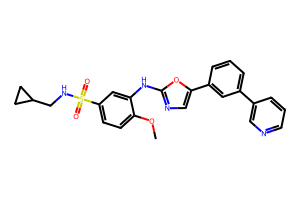

In [45]:
#关于对接后的构象的浏览
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from ipywidgets import interact, interactive, fixed

#定义展示分子各个构象的3D结构的函数
def viewlig(ligmol,view3d,confId=-1):
        ligmolblock = Chem.MolToMolBlock(ligmol,confId=confId)
        view3d.removeAllModels()
        view3d.addModel(ligmolblock,'sdf')
        view3d.setStyle({'stick':{}})
        view3d.setBackgroundColor('0xeeeeee')
        view3d.zoomTo()
        return view3d.show()

#交互式展示对接后的构象3D结构
view3d = py3Dmol.view(width=300,height=200)
interact(viewlig, ligmol=fixed(ligand_mol),view3d=fixed(view3d),
         confId=(1,ligand_mol.GetNumConformers()-1));

#展示配体分子2D结构
DrawingOptions.atomLabelFontSize = 80
DrawingOptions.dotsPerAngstrom = 150
DrawingOptions.bondLineWidth = 2.0

ligmol2d = Chem.RemoveHs(ligand_mol)
ligmol2d.RemoveAllConformers()
Draw.MolToImage(ligmol2d, size=(300, 200))

In [46]:
#分析构象1和蛋白的相互作用，该案例用的是prolif
import prolif as plf #加载prolif包，简称plf

protmol_plf = plf.Molecule.from_rdkit(receptor_mol)
ligmol_tmp = Chem.Mol(ligand_mol,confId=1) # rdkit的分子对象
ligmol_plf=plf.Molecule.from_rdkit(ligmol_tmp) #将rdkit的分子对象转换为prolif的分子对象
fp = plf.Fingerprint()
fp.run_from_iterable([ligmol_plf], protmol_plf)
df=fp.to_dataframe()
df.T

  0%|          | 0/1 [00:00<?, ?it/s]

Frame                            0
ligand protein   interaction      
UNL1   LEU838.A  Hydrophobic  True
                 VdWContact   True
       VAL846.A  Hydrophobic  True
       ALA864.A  Hydrophobic  True
       LYS866.A  Hydrophobic  True
                 VdWContact   True
       GLU883.A  HBAcceptor   True
                 VdWContact   True
       VAL912.A  Hydrophobic  True
                 VdWContact   True
       VAL914.A  Hydrophobic  True
                 VdWContact   True
       GLU915.A  VdWContact   True
       PHE916.A  Hydrophobic  True
                 VdWContact   True
       CYS917.A  Hydrophobic  True
                 HBAcceptor   True
                 HBDonor      True
                 VdWContact   True
       LYS918.A  VdWContact   True
       GLY920.A  VdWContact   True
       ASN921.A  HBAcceptor   True
                 VdWContact   True
       LEU1033.A Hydrophobic  True
                 VdWContact   True
       PHE1045.A Hydrophobic  True
                 PiStacking   True

In [47]:
# 2D interaction map
fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable([ligmol_plf], protmol_plf)
fp_count.plot_lignetwork(ligmol_plf, kind="frame", frame=0, display_all=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
# 3D view with py3dmol
view = fp_count.plot_3d(ligmol_plf, protmol_plf, frame=0, display_all=False)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.